In [9]:
%load_ext autoreload
%autoreload 2

import seaborn # icefire 
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
np.random.seed(42)

import perc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [10]:
### Data Constants
LYAP = 0.043 # Edson et al
DT = 0.25
TEST_PERC = 0.05 
NU = 64 # number of grid points
L = 22.0 # length of the domain
TN = 5000 # num time points = TN / dt 
T_TRIM = 500 # trim first T_TRIM time steps (nothing interesting happens)
DX = L / NU # grid spacing

### RC Configuration
base_config = {
    "Nu": NU,
    "Nr": 5000,
    "alpha": 0.534,
    "beta": 1e-7,
    "rho_A": 0.02,
    "lambda_max": 0.757,
    "sigma": 0.088,
    "bias": 1.915,
    "spinup": 0
}

# Integrate KS

U_train shape: (64, 19000)
U_test shape: (64, 1000)


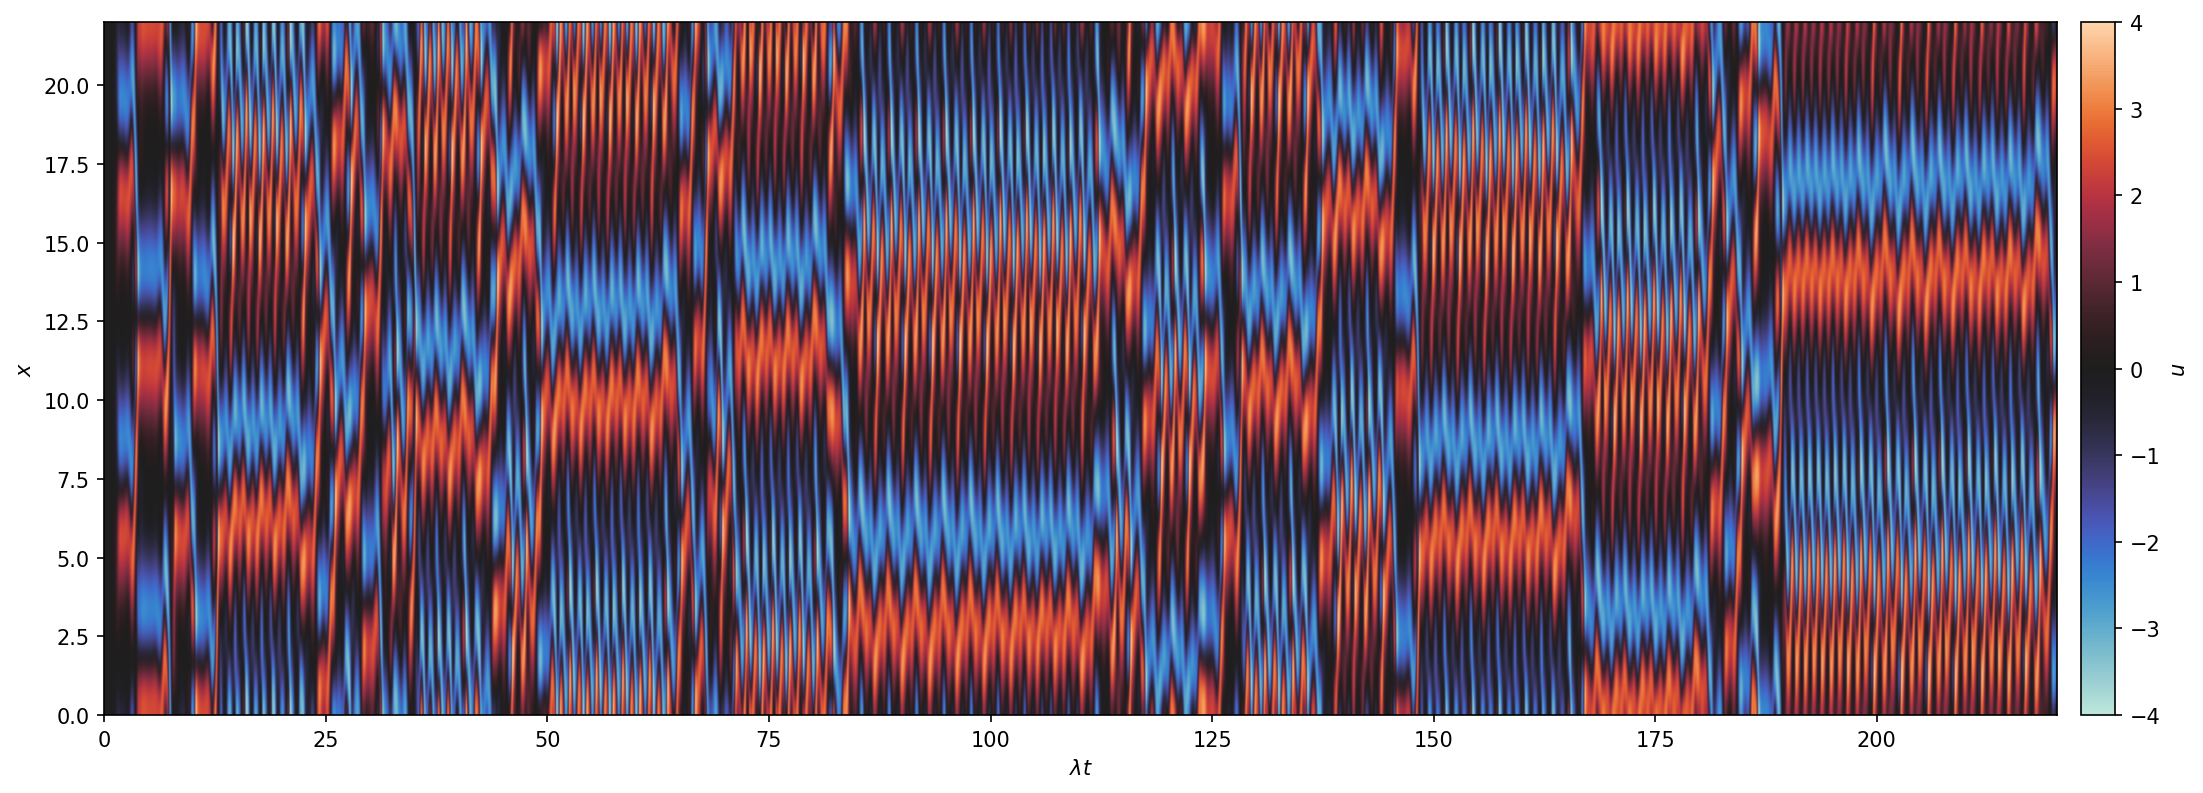

In [11]:
# initial condition
domain = (0, L)
x0 = np.linspace(domain[0], domain[1], NU, endpoint=True) #Note: important to ensure PBC of IC. (however, the spectral solver throws away this point)
u0 = np.sin((32/domain[1])*np.pi * x0)

# integrate lorenz 63
U,t = perc.integrators.KS_1D_PBC(
    u0 = u0,
    tN = TN + T_TRIM*DT,
    dt = DT,
    domain = (0,L),
    Nx=NU
)
U = U[:, T_TRIM:] # chaotic behavior starts later

# train-test split
split_idx = int((1-TEST_PERC) * U.shape[1])
U_train = U[:, :split_idx]
U_test = U[:, split_idx:]
t_train = t[:split_idx] * LYAP
t_test = np.arange(U_test.shape[1]) * DT * LYAP # start from 0
print(f"U_train shape: {U_train.shape}")
print(f"U_test shape: {U_test.shape}")

# plot
t_lyap_full = t * LYAP
perc.vis.imshow_1D_spatiotemp(U,
                              t_lyap_full[-1],
                              domain,
                              vmax = 4.0,
                              vmin = -4.0,
                              cmap = 'icefire',
                              interpolation = 'bicubic',
                              xlabel=r'$\lambda t$')

# Train Unconstrained RC

Training ...
Forecasting ...
Constraint Error CU (data): 5.2093138879180056e-14
Constraint Error CU (RC training): 1.619105423760214e-07
Constraint Error CU (RC forecast): 2.2157954728806556e-05


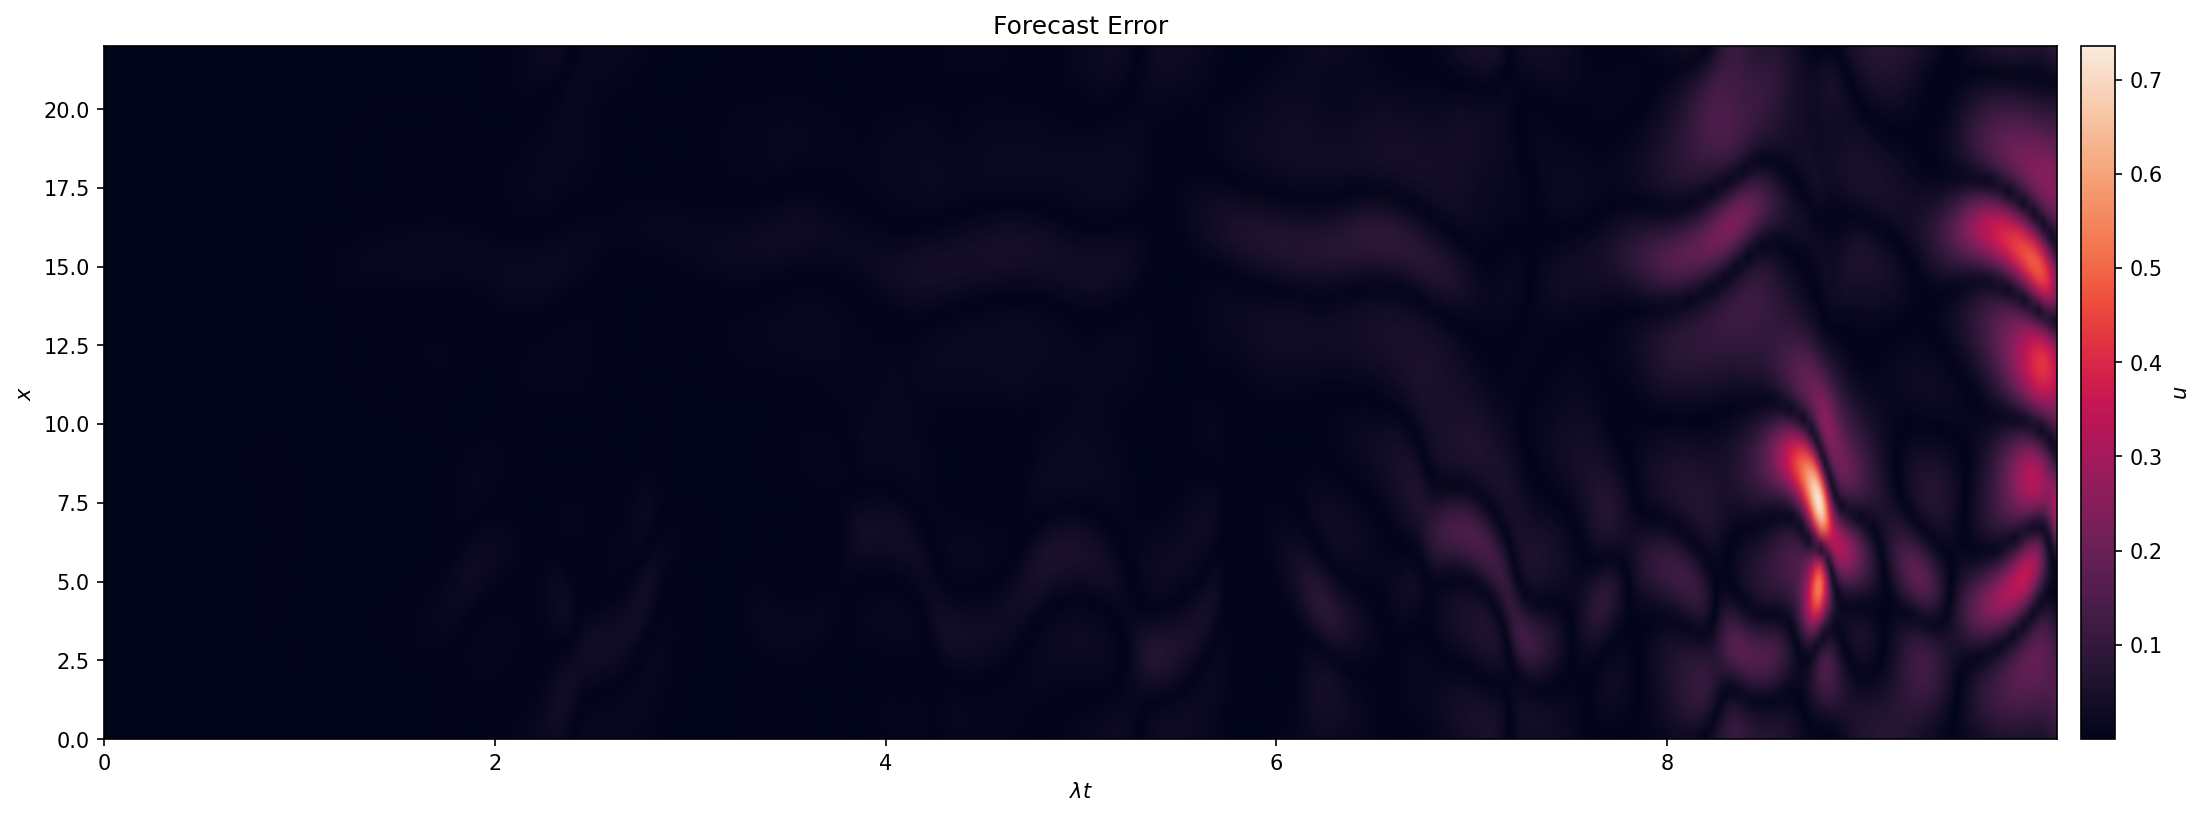

In [12]:
### Train Unconstrained RC ###
print('Training ...')
RC_uc = perc.ReservoirComputer(**base_config)
R = RC_uc.train(U_train)
U_pred_train_uc = RC_uc.W_out @ R #training results

# Forecast
print('Forecasting ...')
n = U_test.shape[1]
U_pred_test_uc = RC_uc.forecast(n)

# Print constraint check
print('Constraint Error CU (data):', np.linalg.norm(scipy.integrate.trapezoid(U_test, dx = DX, axis = 0))) 
print('Constraint Error CU (RC training):', np.linalg.norm(scipy.integrate.trapezoid(U_pred_train_uc, dx = DX, axis = 0)))  
print('Constraint Error CU (RC forecast):', np.linalg.norm(scipy.integrate.trapezoid(U_pred_test_uc, dx = DX, axis = 0))) 

# Plot
fore_err_uc = abs(U_pred_test_uc - U_test)
perc.vis.imshow_1D_spatiotemp(fore_err_uc[:, t_test < 10],
                              t_test[t_test<10][-1],
                              domain,
                              cmap = 'rocket',
                              interpolation = 'bicubic',
                              xlabel=r'$\lambda t$',
                              title='Forecast Error')

# Train Constrained RC

In [13]:
### Define Constraints ###
C_KS = np.ones((1, NU))
C_KS[:, 1:-1] = 2.0
C_KS = DX/2.0 * C_KS # trapezoidal rule

# check the constraint
C_trapz = C_KS @ U_test[:,42]
trapz = scipy.integrate.trapezoid(U_test[:,42], dx=DX) # trapezoidal rule
np.allclose(C_trapz, trapz) # should be true

True

Training ...
Forecasting ...
Constraint Error CU (data): 5.2093138879180056e-14
Constraint Error CU (RC training): 6.58658938896458e-13
Constraint Error CU (RC forecast): 2.751606608897106e-13


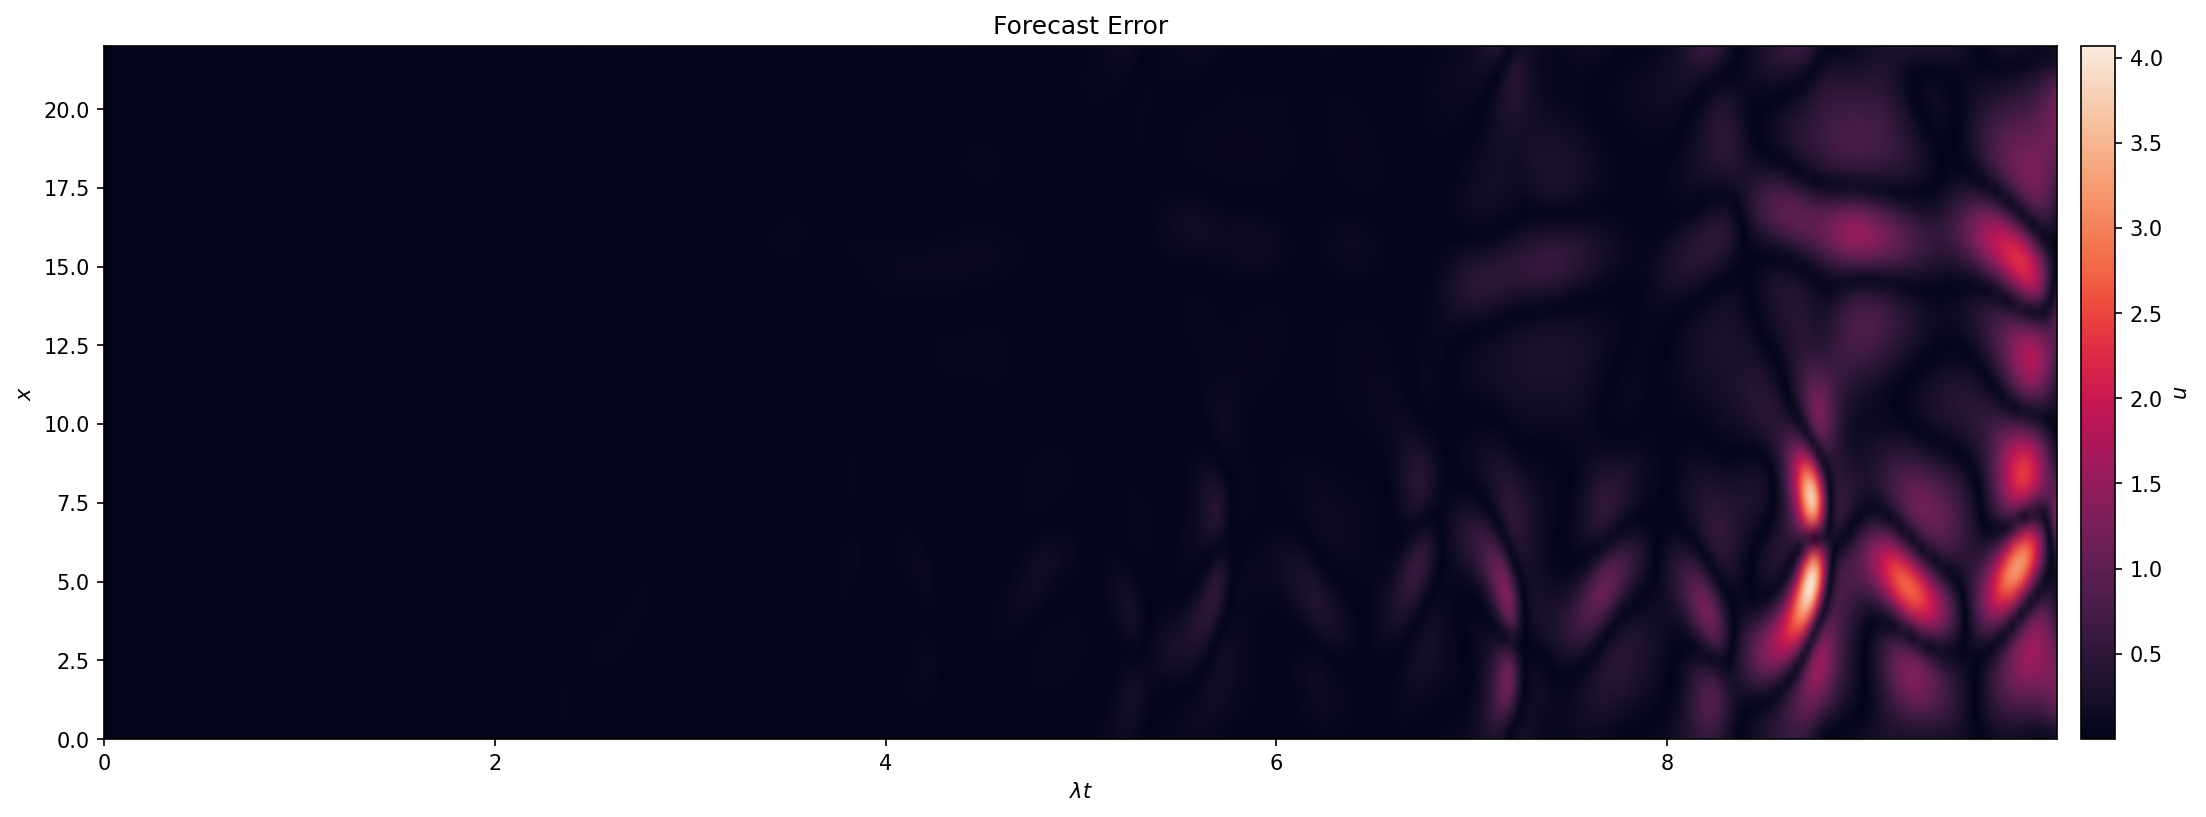

In [14]:
### Train Constrained RC ###
print('Training ...')
RC_c = perc.ReservoirComputer(**base_config)
R = RC_c.train_lh(U_train, C=C_KS)
U_pred_train_c = RC_c.W_out @ R #training results

# Forecast
print('Forecasting ...')
n = U_test.shape[1]
U_pred_test_c = RC_c.forecast(n)

# Print constraint check
print('Constraint Error CU (data):', np.linalg.norm(scipy.integrate.trapezoid(U_test, dx = DX, axis = 0))) 
print('Constraint Error CU (RC training):', np.linalg.norm(scipy.integrate.trapezoid(U_pred_train_c, dx = DX, axis = 0)))  
print('Constraint Error CU (RC forecast):', np.linalg.norm(scipy.integrate.trapezoid(U_pred_test_c, dx = DX, axis = 0))) 

# Plot
fore_err_c = abs(U_pred_test_c - U_test)
perc.vis.imshow_1D_spatiotemp(fore_err_c[:, t_test < 10],
                              t_test[t_test<10][-1],
                              domain,
                              cmap = 'rocket',
                              interpolation = 'bicubic',
                              xlabel=r'$\lambda t$',
                              title='Forecast Error')

# Plot Constraint Adherence

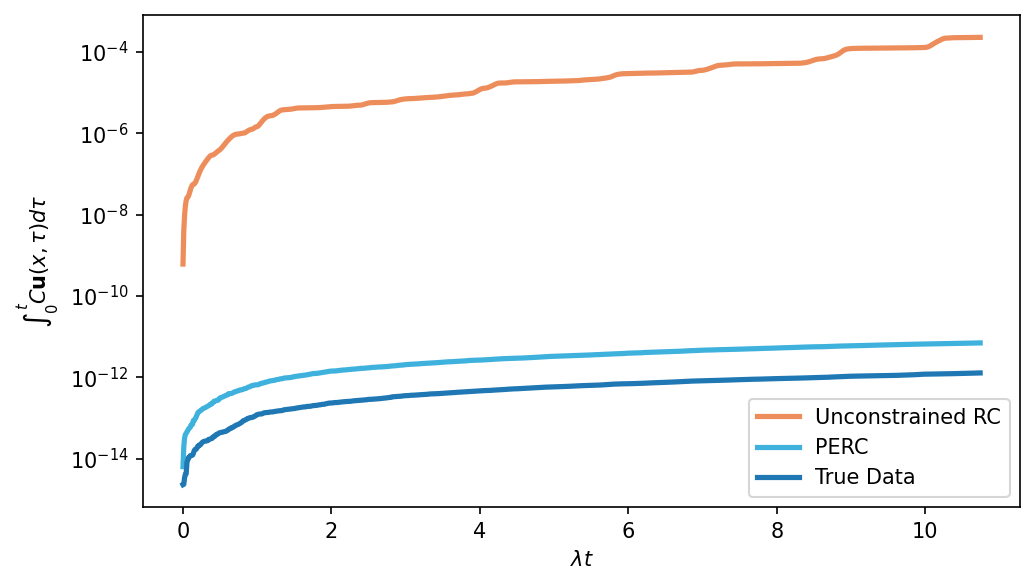

In [15]:
# Calculate cumulative error
constraint_error_test = np.abs(scipy.integrate.trapezoid(U_test, dx=DX, axis=0))
cumul_const_error_test = np.cumsum(constraint_error_test)
constraint_error_uc = np.abs(scipy.integrate.trapezoid(U_pred_test_uc, dx=DX, axis=0))
cumul_cont_error_uc = np.cumsum(constraint_error_uc)
constraint_error_c = np.abs(scipy.integrate.trapezoid(U_pred_test_c, dx=DX, axis=0))
cumul_const_error_c = np.cumsum(constraint_error_c)

# Plot
lw = 2.5
UCRC_color = "#ed8d5b"
PERC_color = "#3fb1dd"
plt.figure(figsize=(7,4), dpi = 150)
plt.plot(t_test, cumul_cont_error_uc, label='Unconstrained RC', linewidth=lw, color=UCRC_color)
plt.plot(t_test, cumul_const_error_c, label='PERC', linewidth=lw, color=PERC_color)
plt.plot(t_test, cumul_const_error_test, label='True Data', linewidth=lw)
plt.xlabel(r'$\lambda t$')
plt.ylabel(r'$\int_0^t C \mathbf{u}(x, \tau) d\tau$')
plt.yscale('log')
plt.legend() 
plt.tight_layout()
plt.show()